In [1]:
from unidecode import unidecode
from collections import Counter
import pandas as pd
import numpy as np
import os, ast

# visualisation
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px

# nlp
import spacy, en_core_web_sm

pd.set_option("display.max_columns", 200)

# Data import

In [2]:
STORAGE_PATH = '../data'
file_name = "flipkart_com-ecommerce_sample_1050.csv"

data = pd.read_csv(os.path.join(STORAGE_PATH, file_name))

# Data exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [4]:
data.product_category_tree.nunique()

642

In [5]:
categories = data.product_category_tree.apply(ast.literal_eval)
categories = categories.apply(pd.Series)
categories = categories[0].apply(lambda x: x.split(' >> '))
categories = categories.apply(pd.Series)
categories = categories.add_prefix('category_')
data = pd.concat([data, categories], axis=1)

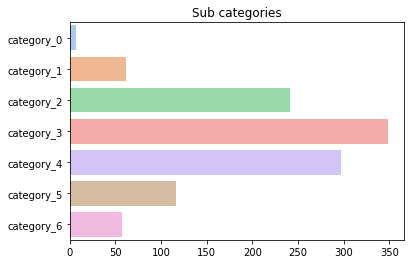

In [6]:
plt.figure()
sns.barplot(y = categories.nunique().index, x = categories.nunique().values, palette='pastel')
plt.title('Sub categories')
plt.show()

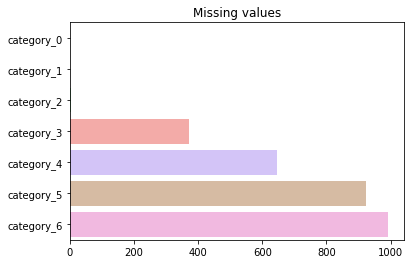

In [7]:
plt.figure()
sns.barplot(y = categories.isna().sum().index, x = categories.isna().sum().values, palette='pastel')
plt.title('Missing values')
plt.show()

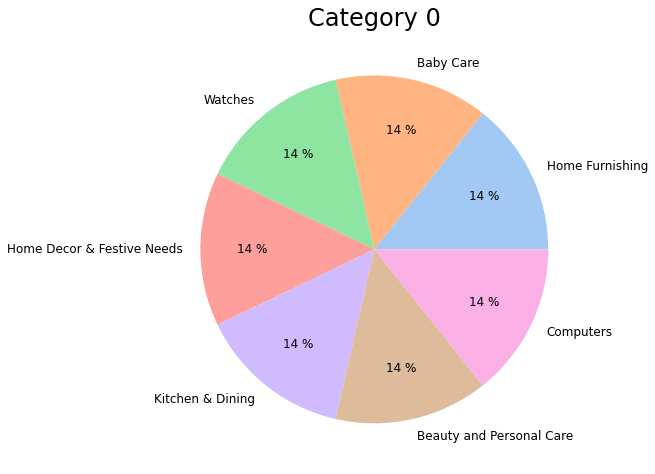

In [8]:
category_0_value_counts = data.category_0.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(x = category_0_value_counts.values, labels= category_0_value_counts.index, autopct='%1.f %%', 
        startangle=0,  pctdistance=0.7, colors = sns.color_palette('pastel'), 
        textprops={'fontsize': 12})
plt.title('Category 0', fontdict={'fontsize': 24})
plt.show()

In [9]:
categories['category_1_count'] = categories.category_1.apply(lambda x : dict(categories.category_1.value_counts())[x])

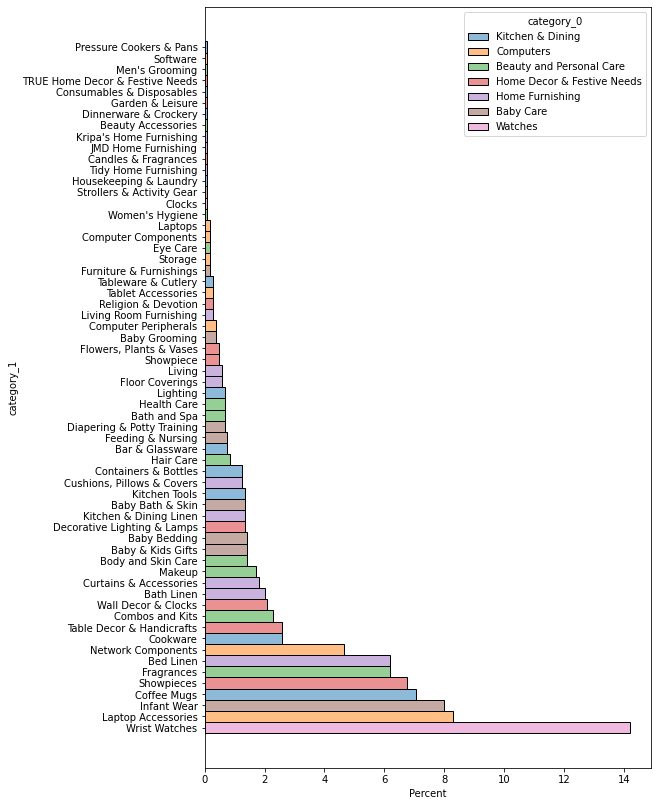

In [10]:
plt.figure(figsize=(8, 14))
sns.histplot(data = categories.sort_values('category_1_count'), y = 'category_1', hue = 'category_0', stat='percent')
plt.show()

In [11]:
fig = px.sunburst(data, path=['category_0', 'category_1'])
fig.show()

# Text analysis

In [12]:
nlp = en_core_web_sm.load()
corpus = data.description

## Tokens

### Without remove stop words

In [13]:
def tokenizer(text):
    doc = nlp(unidecode(text.lower()))
    tokens = [token.lemma_ for token in doc if not token.is_punct and token.is_alpha]
    return tokens

data['tokens'] = data.description.apply(tokenizer)

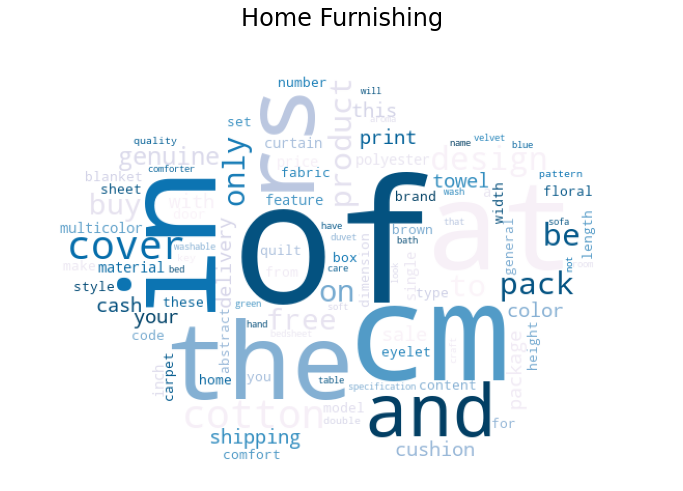

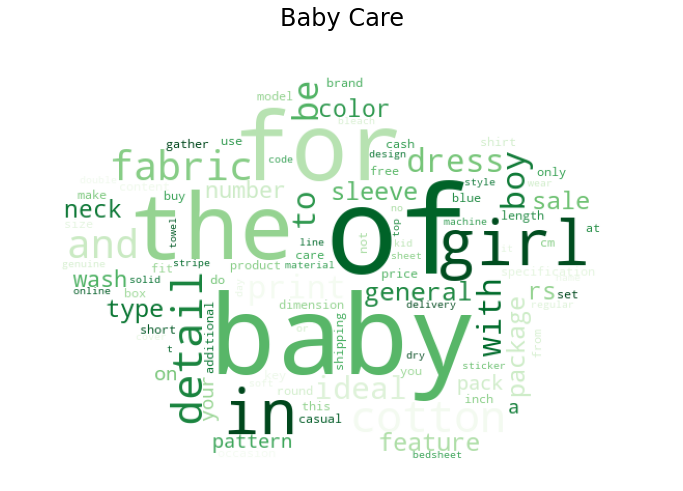

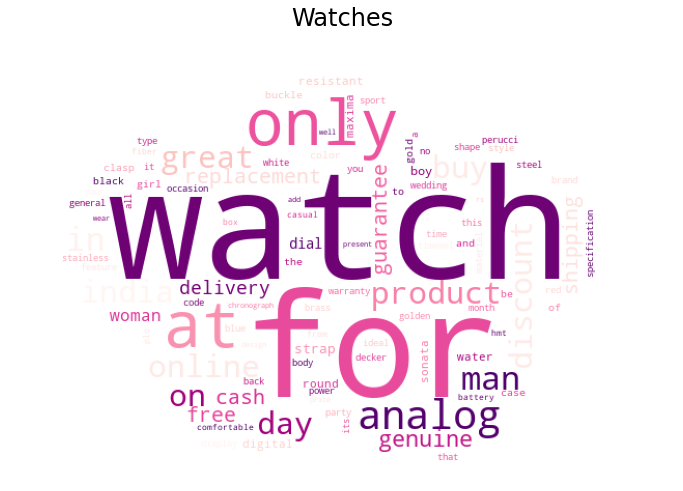

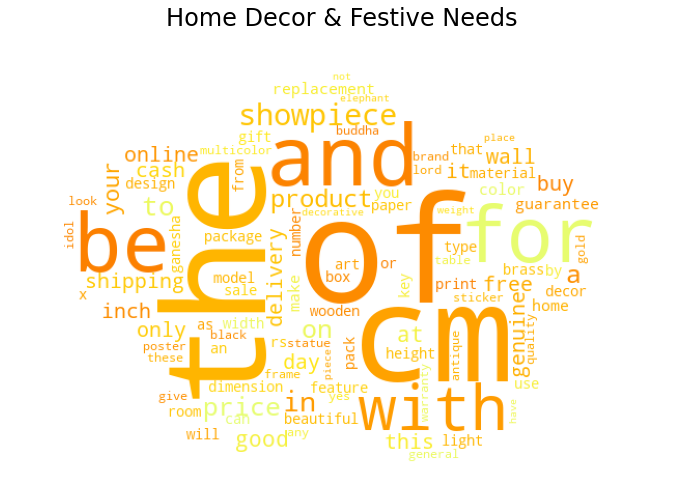

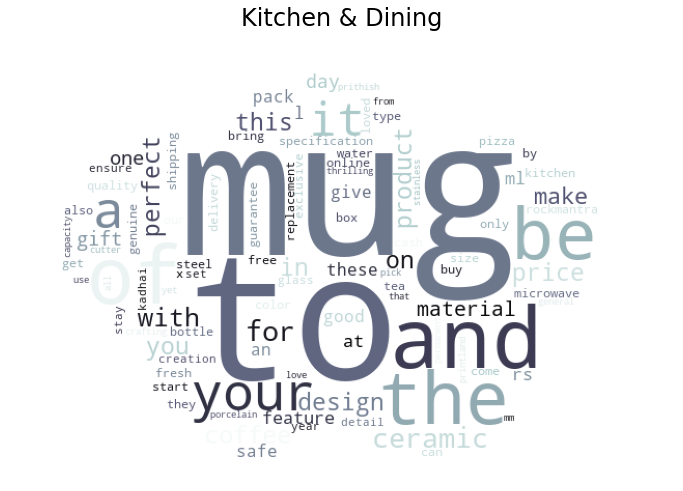

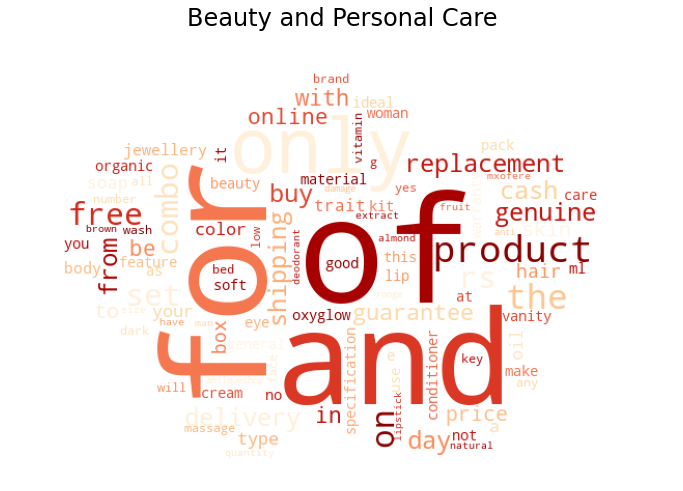

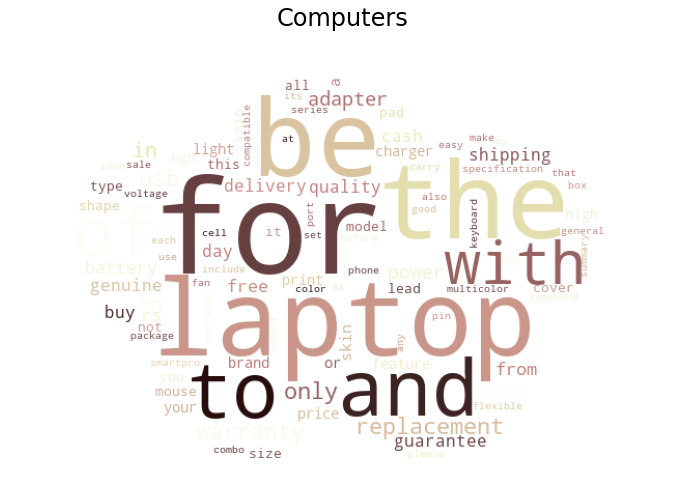

In [14]:
mask = np.array(Image.open(os.path.join(STORAGE_PATH, "Capture-décran-2021-01-27-à-17.16.44.png")))
mask[mask == 1] = 255
colors = ['PuBu_r', 'Greens_r', 'RdPu_r', 'Wistia_r','bone', 'OrRd_r', 'pink']

for color, category in zip(colors, data.category_0.unique()):
    wc = WordCloud(width=800, height=400, random_state=1, colormap=color, background_color='white', mask = mask, max_words=100)
    category_tokens = [element for sub in data.loc[data.category_0 == category].tokens for element in sub]
    category_tokens_frequencies = Counter(category_tokens)
    plt.figure(figsize=(12, 12))
    plt.title(category, fontdict={'fontsize': 24})
    plt.imshow(wc.generate_from_frequencies(category_tokens_frequencies))
    plt.axis("off")
    plt.show()

### With remove stop words

In [15]:
tokens_unique = [element for sub in data.tokens.apply(lambda x: list(set(x))) for element in sub]
additional_stop_words = [word for word, freq in Counter(tokens_unique).items() if (freq / len(data)) > 0.15]

In [16]:
len(additional_stop_words)

48

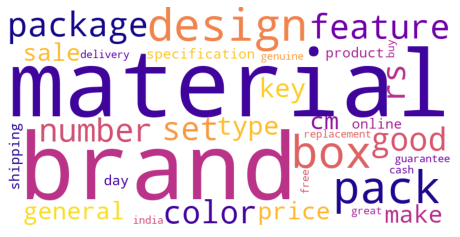

In [17]:
plt.figure(figsize=(8, 8))
wc = WordCloud(width=800, height=400, random_state=1, background_color='white', max_words=200, colormap='plasma')
plt.imshow(wc.generate(' '.join(additional_stop_words)))
plt.axis("off")
plt.show()

In [18]:
def tokenizer(text):
    doc = nlp(unidecode(text.lower()))
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and token.is_alpha]
    return tokens

data['tokens_sw'] = data.description.apply(tokenizer)

In [19]:
def tokenizer(text):
    doc = nlp(unidecode(text.lower()))
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and token.is_alpha]
    tokens = [token for token in tokens if len(token) > 1 and not token in additional_stop_words]
    return tokens

data['tokens_swa'] = data.description.apply(tokenizer)

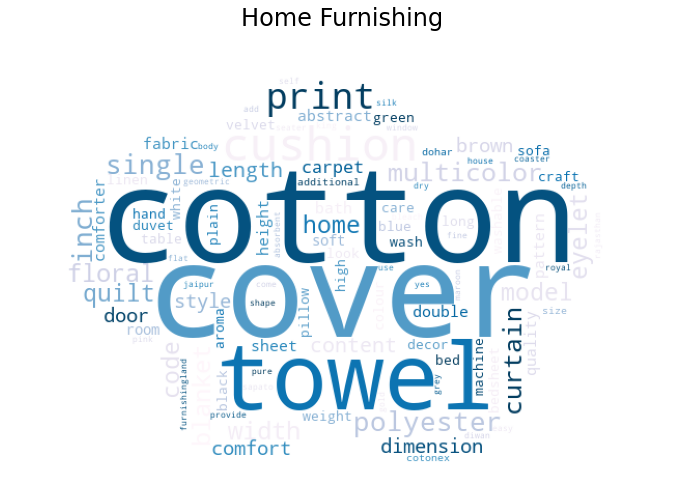

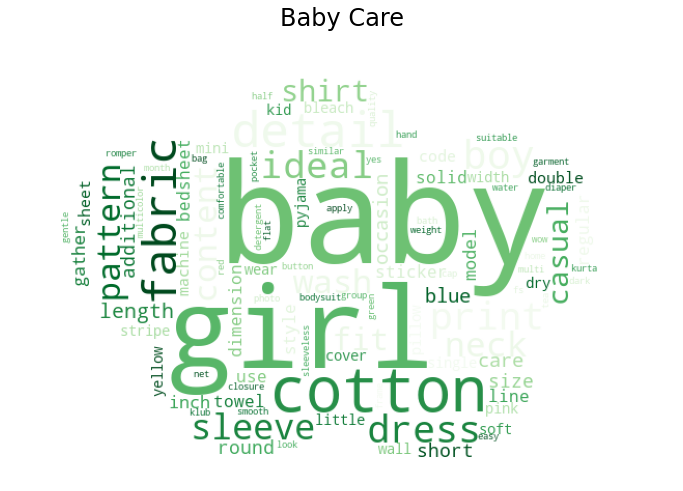

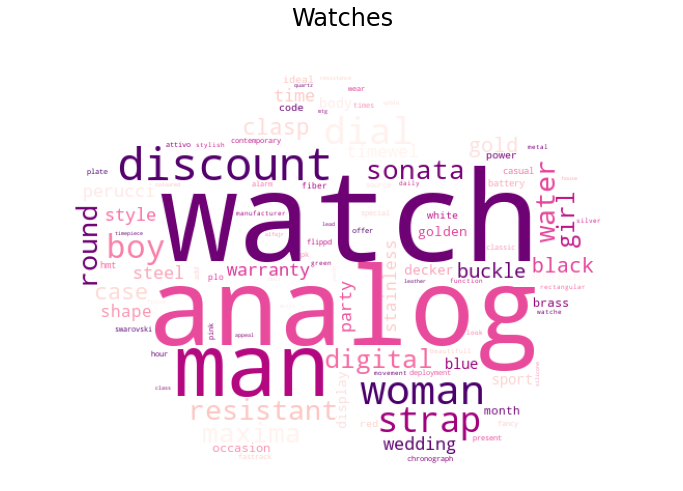

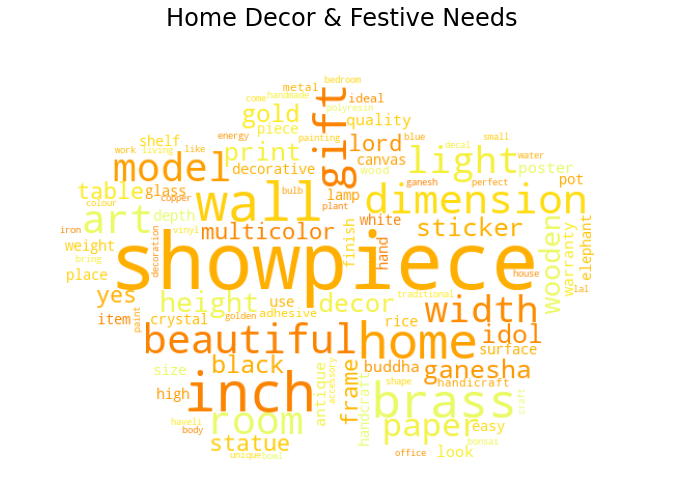

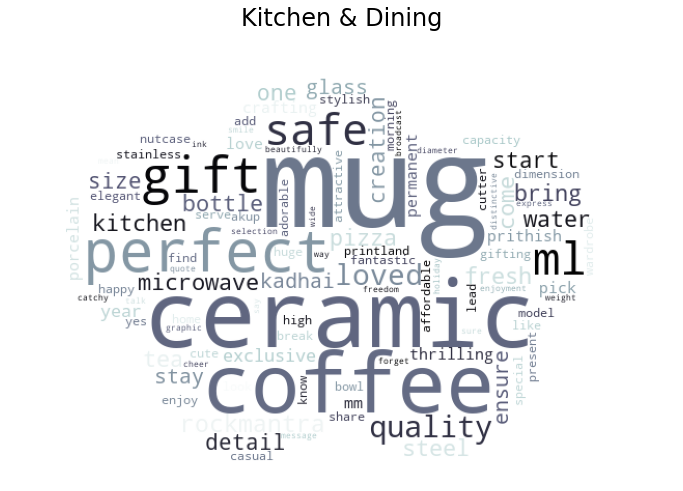

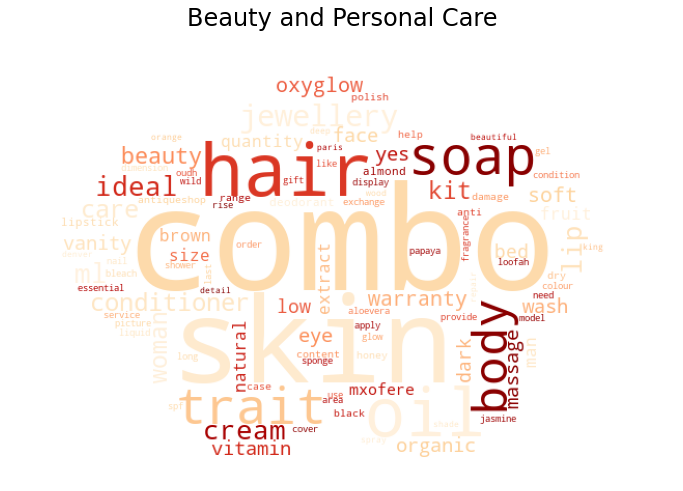

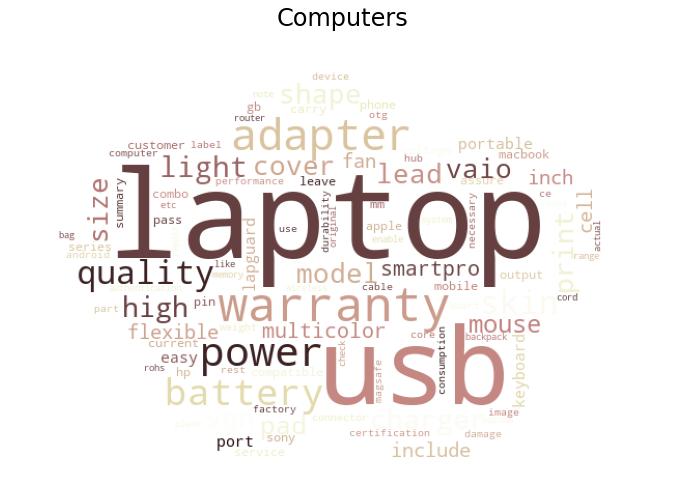

In [20]:
for color, category in zip(colors, data.category_0.unique()):
    
    wc = WordCloud(width=800, height=400, random_state=1, colormap=color, background_color='white', mask = mask, max_words=100)
    category_tokens = [element for sub in data.loc[data.category_0 == category].tokens_swa for element in sub]
    category_tokens_frequencies = Counter(category_tokens)
    plt.figure(figsize=(12, 12))
    plt.title(category, fontdict={'fontsize': 24})
    plt.imshow(wc.generate_from_frequencies(category_tokens_frequencies))
    plt.axis("off")
    plt.show()

### With pos tagging

In [21]:
def tokenizer(text):
    doc = nlp(unidecode(text.lower()))
    tag_list = ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS']
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and token.is_alpha and token.tag_ in tag_list]
    return tokens

data['tokens_sw_tag'] = data.description.apply(tokenizer)

def tokenizer(text):
    doc = nlp(unidecode(text.lower()))
    tag_list = ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS']
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and token.is_alpha and token.tag_ in tag_list]
    tokens = [token for token in tokens if len(token) > 1 and not token in additional_stop_words]

    return tokens

data['tokens_swa_tag'] = data.description.apply(tokenizer)

In [22]:
columns = [('tokens', 'All'), ('tokens_sw', 'Stopwords'), ('tokens_swa', 'Additionals stopwords'), 
           ('tokens_sw_tag', 'Stopwords & tags'), ('tokens_swa_tag', 'Additionals stopwords & tags')]

chart_data = pd.DataFrame(columns=['Number', 'Preprocessing stage', 'Tokens'])

for column, display_name in columns:
    tokens = [element for sub in data[column] for element in sub]
    tokens_unique = set(tokens)
    chart_data = chart_data.append(
        [{'Number': len(tokens), 'Preprocessing stage': display_name, 'Tokens': 'total'},
         {'Number': len(tokens_unique), 'Preprocessing stage': display_name, 'Tokens': 'unique'}], ignore_index=True)

In [27]:
fig = px.funnel(chart_data.infer_objects(), x='Number', y='Preprocessing stage', color='Tokens')
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.show()

## Bivariate analysis

In [24]:
data['Number of tokens'] = data.tokens.apply(lambda x: len(x))
data["Number of unique tokens"] = data.tokens.apply(lambda x: len(set(x)))

fig = px.box(data, x = ['Number of tokens', 'Number of unique tokens'], 
             color='category_0', labels={'variable':'', 'category_0': 'Category', 'value':''})
fig.show()
data.drop(columns=['Number of tokens', 'Number of unique tokens'], inplace=True)

In [25]:
category_df = pd.DataFrame()
for category in data.category_0.unique():
    nb_text = len(data.loc[data.category_0 == category])
    category_tokens = [element for sub in data.loc[data.category_0 == category].tokens_swa for element in sub]
    category_tokens_frequencies = Counter(category_tokens)
    category_tokens_most_common = category_tokens_frequencies.most_common(10)
    category_tokens_most_common = [(word, round(freq / nb_text, 5)) for word, freq in category_tokens_most_common]
    category_tokens_df = pd.DataFrame(category_tokens_most_common, columns=['word','freq'])
    category_tokens_df["category"] = category

    category_df = pd.concat([category_df, category_tokens_df])  

fig = px.treemap(category_df, path=[px.Constant("Categories"), 'category', 'word'], values='freq', color='freq', 
                 color_continuous_scale='geyser')
fig.show()

# Save data

In [26]:
data.to_csv(os.path.join(STORAGE_PATH, 'data.csv'), index=False)